<a href="https://colab.research.google.com/github/severinov-yuriy/dls_hw/blob/main/hw_language_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)

В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk
import re

from collections import Counter
from typing import List

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [5]:
# Загрузим датасет
dataset = load_dataset('imdb')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [10]:
word_thresholds = (3, 33)
sentences = dataset['train']['text']
sentences = [nltk.sent_tokenize(re.sub('<[^>]*>', ' ', text)) for text in sentences]              # разделим на предложения
sentences = [re.sub(r'[^a-z] *', ' ', sen.lower()) for text in sentences for sen in text]         # предобработаем предложения и избавимся от двойной вложенности
sentences = [sen for sen in sentences if len(sen.split()) in range(*word_thresholds)]             # удалим слишком длинные и слишком короткие предложения
sentences[:5]

['i rented i am curious yellow from my video store because of all the controversy that surrounded it when it was first released in      ',
 'the plot is centered around a young swedish drama student named lena who wants to learn everything she can about life ',
 'in between asking politicians and ordinary denizens of stockholm about their opinions on politics she has sex with her drama teacher classmates and married men ',
 'what kills me about i am curious yellow is that   years ago this was considered pornographic ',
 'really the sex and nudity scenes are few and far between even then it s not shot like some cheaply made porno ']

In [11]:
print("Всего предложений:", len(sentences))

Всего предложений: 261805


Посчитаем для каждого слова его встречаемость.

In [12]:
words = Counter()

for sen in tqdm(sentences):
    for word in re.sub(r'[^a-z]', ' ', sen).split(' '):
        words[word] += 1


  0%|          | 0/261805 [00:00<?, ?it/s]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [13]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000

for word, _ in words.most_common(vocab_size):
    vocab.add(word)


In [14]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [15]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [16]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [17]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx].split(' ')]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [18]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:]
    }

    return new_batch

In [24]:
# странное разделение, что бы колаб мне не отрезал ресурсы больше)
train_sentences, eval_sentences = train_test_split(sentences, test_size=0.6)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.9)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 8

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [25]:
len(train_dataloader), len(eval_dataloader), len(test_dataloader)

(13091, 1964, 17672)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возмоэные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [26]:
def evaluate(model, criterion, dataloader, pbar) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        batches = len(dataloader)
        n_batch = 0
        for batch in dataloader:
            n_batch += 1
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())
            pbar.set_postfix({'evaluation: n_batch/total': f'{n_batch}/{batches}',
                              'eval perplexity': sum(perplexity) / len(perplexity)})

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [27]:
def train_model(model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch=1) -> list:
    losses = []
    perplexities = []
    perplexity = 0

    for epoch in (pbar := tqdm(range(num_epoch))):
        pbar.set_description(f'Epoch {epoch}:')
        epoch_losses = []
        model.train()

        batches = len(train_dataloader)
        n_batch = 0
        for batch in train_dataloader:
            n_batch += 1
            pbar.set_postfix({'training: n_batch/total': f'{n_batch}/{batches}',
                              'eval perplexity': perplexity})
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
        losses.append(sum(epoch_losses) / len(epoch_losses))

        perplexity = evaluate(model, criterion, eval_dataloader, pbar)
        perplexities.append(perplexity)

    return losses, perplexities

In [28]:
def plot_result(losses: list, perplexities:list):
    fig, (ax1, ax2) = plt.subplots(1, 2, layout='tight', figsize=(15, 5))
    ax1.plot(np.arange(len(losses)), losses, color='orchid')
    ax2.plot(np.arange(len(perplexities)), perplexities, color='darkcyan')
    ax1.set_title('Losses')
    ax2.set_title('Perplexities')

    plt.xlabel("epoch")
    plt.show()

### Первый эксперимент: простой GRU (2 балла)

Определите архитектуру модели и обучите её.

In [29]:
class LanguageModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

#### Однослойный GRU

In [30]:
gru1_model = LanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers=1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(gru1_model.parameters())

In [31]:
losses, perplexities = train_model(gru1_model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

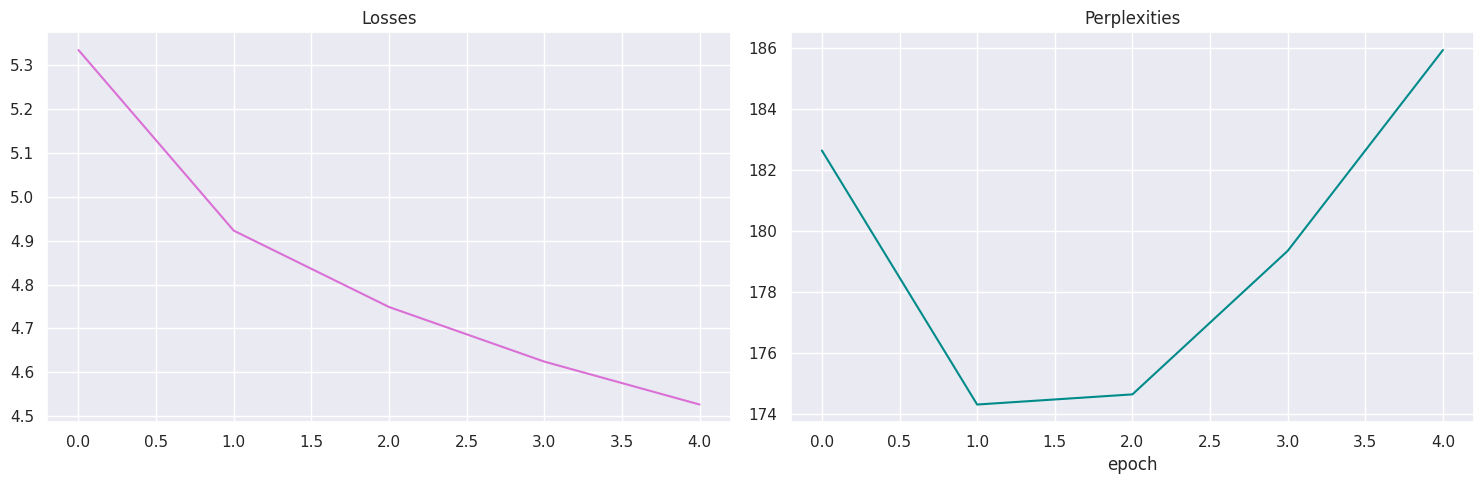

In [32]:
plot_result(losses, perplexities)

#### Трехслойный GRU

In [37]:
gru3_model = LanguageModel(hidden_dim=256, vocab_size=len(vocab), num_layers=3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(gru3_model.parameters())

In [38]:
losses, perplexities = train_model(gru3_model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

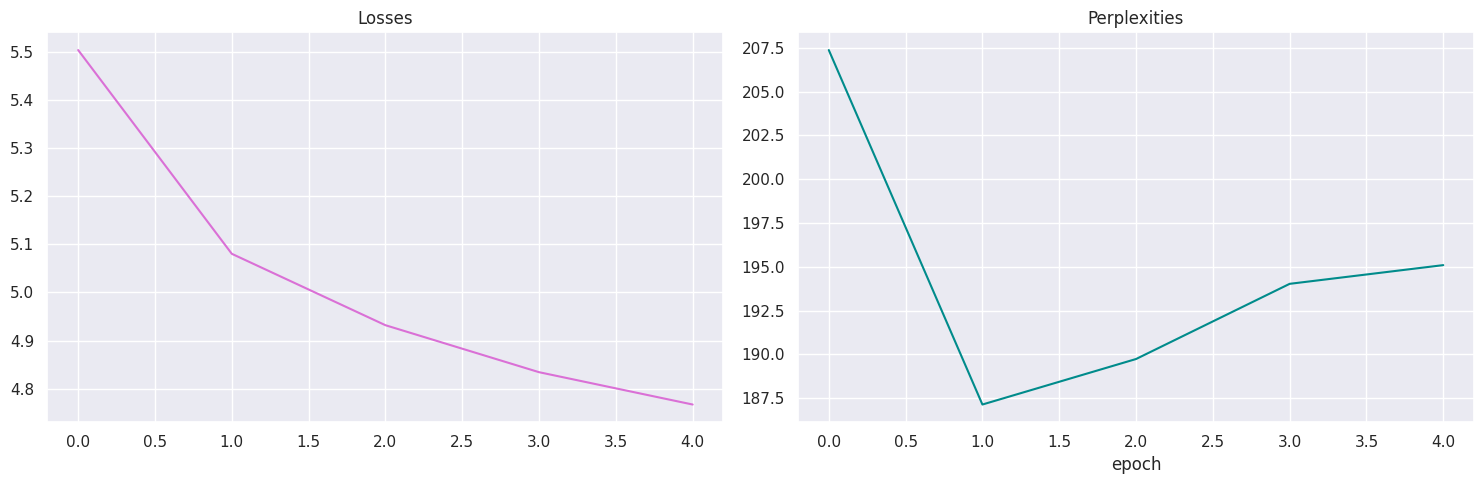

In [39]:
plot_result(losses, perplexities)

### Второй эксперимент: простой LSTM (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

In [33]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_layers: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection


#### Однослойный LSTM

In [34]:
lstm1_model = LSTMModel(hidden_dim=256, vocab_size=len(vocab), num_layers=1).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(lstm1_model.parameters())

In [35]:
losses, perplexities = train_model(lstm1_model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

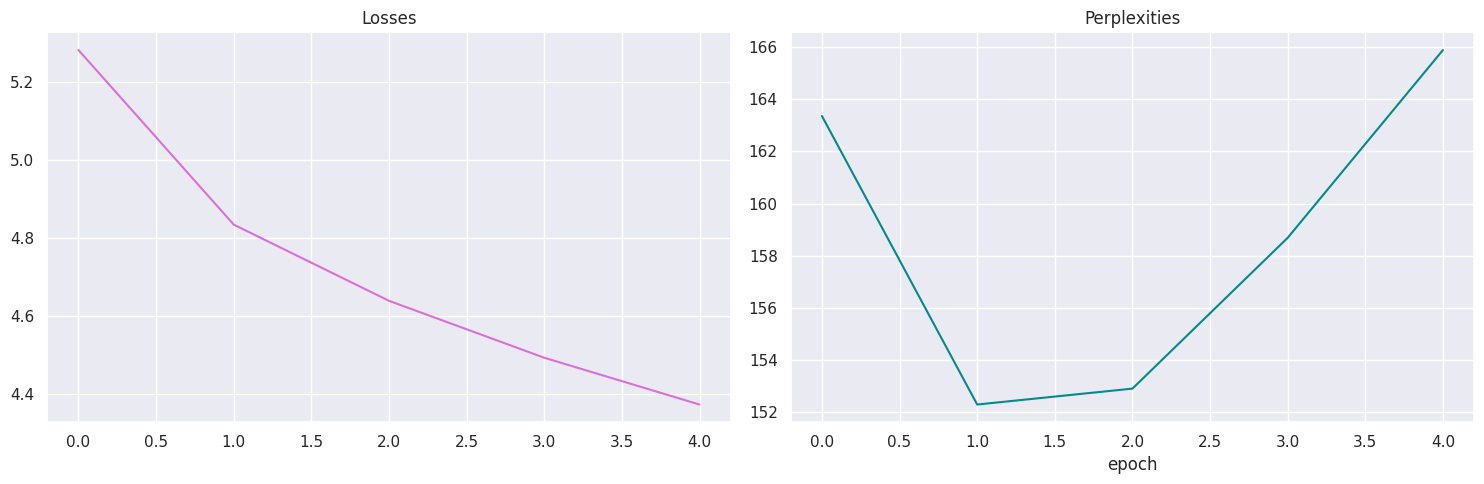

In [36]:
plot_result(losses, perplexities)

#### Трехслойный LSTM

In [40]:
lstm3_model = LSTMModel(hidden_dim=256, vocab_size=len(vocab), num_layers=3).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
optimizer = torch.optim.Adam(lstm3_model.parameters())

In [41]:
losses, perplexities = train_model(lstm3_model, criterion, optimizer, train_dataloader, eval_dataloader, num_epoch=5)

  0%|          | 0/5 [00:00<?, ?it/s]

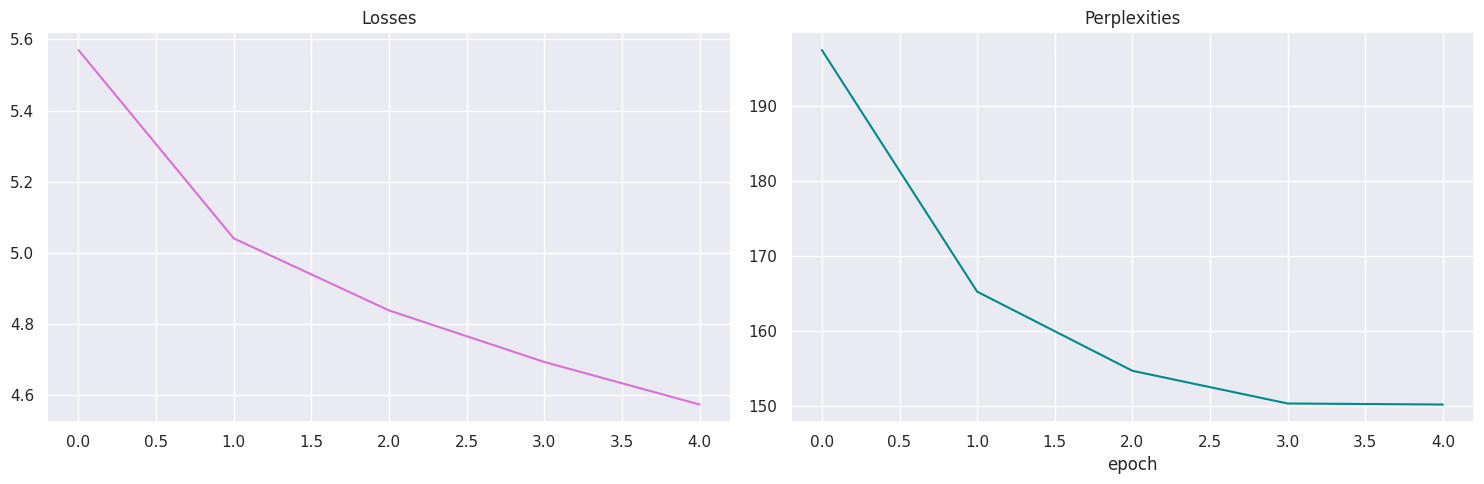

In [42]:
plot_result(losses, perplexities)

### Отчет (2 балла)
> Прошу простить мне мою скупость, но когда я пытался исследовать другие варианты и достичь лучшего качества, колаб лишил меня ресурсов(

Все модели обучались на довольно маленьком объеме данных, что не позволило им достичь оптимальных значений. Длительность обучения каждой из моделей - 5 эпох.

Первая модель - с одним GRU слоем достигла лучшей perplexity в 174 уже на второй эпохе, после чего этот показатель только повышался.

Вторая модель - с тремя GRU слоями показала себя не лучшим образом и начав с довольно высокого perplexity, не достигла даже худшего уровня первой модели. Вероятно более глубокую сеть нужно обучать дольше, чем простую, что бы достичь стабильных результатов.

Третья модель - с одним LSTM слоем показала себя довольно хорошо, на второй эпохе достигнув почти 152 perplexity.

Четвертая модель - с тремя LSTM слоями повела себя совсем иначе чем трехслойная GRU. Она обучалась все эпохи и снизила perplexity до 150, что относительно других моделей очень даже неплохо.

Интересный паттерн показали все модели, "рухнув" в яму в самом начале обучения с сильным откатом на следующих эпохах. Кажется, что это переобучение в силу маленького тренировочного датасета, который модель легко и быстро запоминает.

In [65]:
from prettytable import PrettyTable
models = [gru1_model, gru3_model, lstm1_model, lstm3_model]
scores = []
for model in (pbar:=tqdm(models)):
    model = model.to(device)
    scores.append(evaluate(model, criterion, test_dataloader, pbar))
t = PrettyTable(['Model', 'Test score'])
t.add_row(['gru1_model', scores[0]])
t.add_row(['gru3_model', scores[1]])
t.add_row(['lstm1_model', scores[2]])
t.add_row(['lstm3_model', scores[3]])
print(t)


  0%|          | 0/4 [00:00<?, ?it/s]

+-------------+--------------------+
|    Model    |     Test score     |
+-------------+--------------------+
|  gru1_model | 183.98416138148622 |
|  gru3_model | 194.06777377601338 |
| lstm1_model | 164.79559347078023 |
| lstm3_model |  149.742016468074  |
+-------------+--------------------+


Ожидаемо лучшего качества на тестовом датасете достигла модель с тремя слоями LSTM, как и на валидационной выборке. Да, значение метрики невелико, но с большими ресурсами, на большем числе эпох и слоев, вероятно можно будет добиться гораздо лучшего качества.